# TP1: Spectral Clustering - Graphs in Machine Learning

Student: Pierre-Louis Guhur pguhur@ens-paris-saclay.fr

**1.1. What is the purpose of the option parameter in `worst_case_blob`?**

`worst_case_blob` has three parameters:
- `num_samples` is the size of samples dividing to all clusters (default in sklearn is 100);
- `gen_pam`: the offset of the outlier, it allows to create a cluster with a point outside of the cluster;
- `blob_var`: is the variance of the clusters


**1.2. What happens when you change the generating parameter of `worst_case_blob` in `how_to_choose_espilon` and run the function? What if the parameter is very large?**

The following graph shows the consequence of `gen_pam` over the distribution. As explained in **1.1**,  an outlier point can be seen generated outside of the cluster.

If the parameter is too large, the distribution becomes two seperated clusters.

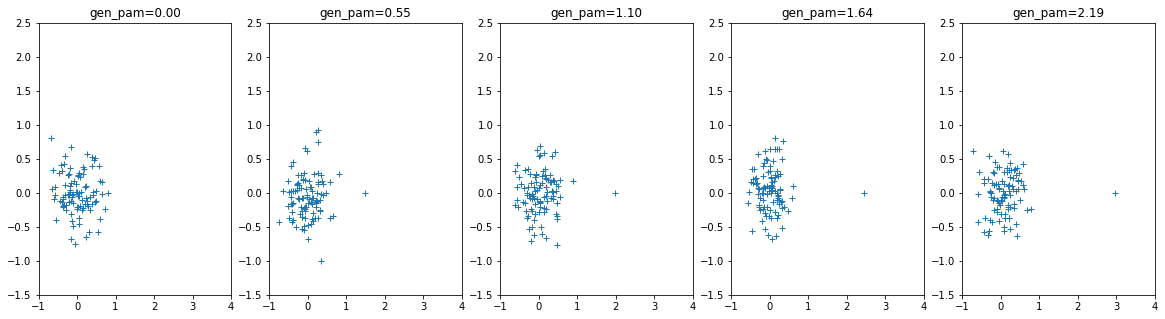

In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.datasets as skd
from graph_construction.func import *
from spectral_clustering.func import *
import scipy as sp

blob_var = 0.3
coeff = range(5)
plt.figure(figsize=(20,5))
for i,c in enumerate(coeff):
    gen_pam = c*np.sqrt(blob_var)
    [X, Y] = worst_case_blob(100,gen_pam,blob_var)
    W = build_similarity_graph(X, eps=0, k=1)
    plt.subplot(1,len(coeff), i+1)
    plt.plot(X[:,0],X[:,1],"+")
    plt.title(f"gen_pam={gen_pam:.2f}")
    plt.xlim((-1,4))
    plt.ylim((-1.5,2.5))
plt.show()

In the following, we took `gen_pam = 2*sqrt(blob_var)` to get a reasonable outlier.


**1.3. Using `plot_similarity_graph` and one of the datasets, compare `k-nn` to $\epsilon$ graphs. When is it easier to build a connected graph using `k-nn`? When using $\epsilon$ graphs?**

In the example of `worst_case_blob`, $\epsilon$ is chosen relatively high. As a consequence, the Laplacian is full of value and the computation of the eigenvalues is noisy (as seen in later experiments).

`k-nn` is more appropriate when the distance between the neighboor points is not the same. For example, when there is an outlier.

/Users/pierre-louis/src/MVA/GraphsInML/code_material_python/helper.py:60: RuntimeWarning: overflow encountered in add
  adjn+=adji


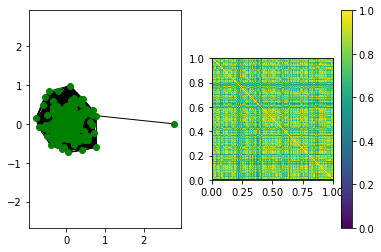

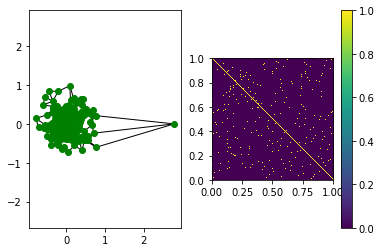

In [93]:
[X, Y] = worst_case_blob(200,1.8)


def how_to_choose_epsilon(X, var = 1.0):

    dists = sd.cdist(X, X, 'euclidean')
    similarities = np.exp(-dists/var/2)

    max_tree = max_span_tree(similarities)

    eps = np.min(similarities[max_tree > 0])
    similarities[similarities < eps-1e-6] = 0
    return eps, similarities

eps, W = how_to_choose_epsilon(X)
plot_graph_matrix(X,Y,W, title=f"Using eps={eps:.2f}")


k = 4
plot_similarity_graph(X,Y, k=k, title=f"Using knn={k}")

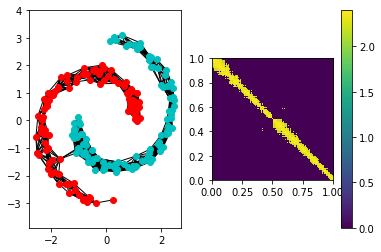

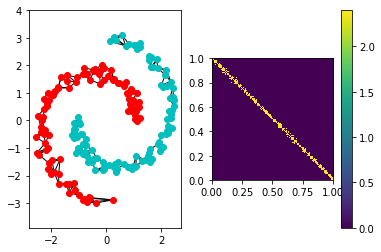

In [101]:
data = scipy.io.loadmat("data/data_2moons.mat")
X = data['X']
Y = data['Y']

eps, W = how_to_choose_epsilon(X)
plot_similarity_graph(X,Y, eps=eps, title=f"Using eps={eps:.2f}", log=True)
plot_similarity_graph(X,Y, k=5, title=f"Using knn=5", log=True)

In this graph, the $\epsilon$-graph is not the most appropriate choice. Indeed, an outlier is slighlty far from the blob, and thus $\epsilon$ is estimated at an important value.
    
Two consequences are favorable to `k-nn`-graph:
- its Laplacian is sparser Laplacian, which simplifies the computation of the eigenvalues;
- two points (and their symmetrics) are wrong in the $\epsilon$-Laplacian: their are located in upper right part of the matrix and thus will lead to misclassified point.


## 2. Spectral Clustering

In [88]:
import numpy as np
import matplotlib.pyplot as pyplot
import scipy.spatial.distance as sd
import sklearn.cluster as skc
import sklearn.metrics as skm
import scipy as sp
import sys
import os

path=os.path.dirname(os.getcwd())
sys.path.append(path)
from helper import *
from graph_construction.func import *
from spectral_clustering.func import *

# load the data
in_data = sp.io.loadmat('data/data_2blobs')
X = in_data['X']
Y = in_data['Y']
dists = sd.cdist(X, X, 'euclidean')**2
exponential_euclidean = np.exp(-dists)
var = np.var(exponential_euclidean)
num_classes = len(np.unique(Y))

**2.1. Build a graph starting from the data loaded in `two_blobs_clustering`, and remember to keep the graph connected. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the builtin k-means and compare the results.**

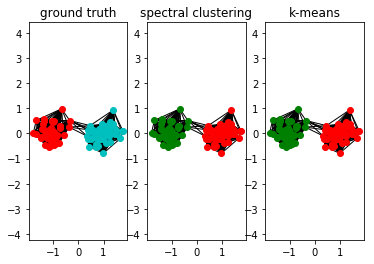

/Users/pierre-louis/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


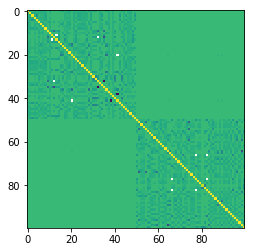

In [89]:
eps=0 # 0.1 also works
k=30
laplacian_normalization = 'sym'       #either 'unn', 'sym' or 'rw' 
chosen_eig_indices = np.arange(1,2) # indices of the ordered eigenvalues to pick

W = build_similarity_graph(X, var=var, eps=eps, k=k)
L = build_laplacian(W, laplacian_normalization=laplacian_normalization)
Y_rec, E = spectral_clustering(L, chosen_eig_indices, num_classes)
threshold = E[chosen_eig_indices[-1]]+1e-2
plot_clustering_result(X, Y, L, Y_rec,skc.KMeans(num_classes).fit_predict(X))
plt.imshow(np.log(1e-1+L))

To select the parameters, I changed the value of $\epsilon$ until the graph of the second eigenvector could clearly be separated into two clusters. 

The second eigenvector is quite noisy. In order to improve the robustness of the algorithm, I chose to include also the third eigenvector, as it is associated to an almost-zero eigenvalue.

The following graphs justifies my choice.

The clustering assignement is done from a k-means clustering around the eigenvector as it is a general and efficient. But, I could have also directly cutted the second eigenvector to zero: all positive values would be considered as a same cluster, while all negative values to the other cluster.

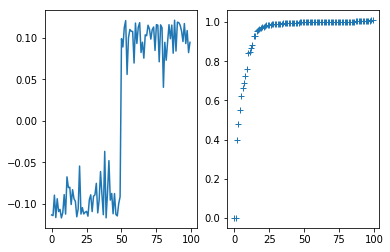

In [95]:
Y_rec, E = spectral_clustering(L, chosen_eig_indices, num_classes, debug=True)

**2.2.
Build a graph starting from the data loaded in `two_blobs_clustering`, 
but this time makes it so that the two components are separate. 
How do you choose which eigenvectors to use in this case? Motivate your answer.**

To get to the 2 components separated, I need an higher value of $\epsilon$, then I select the eigenvalues as before. Here, the random-walk Laplacian is the most efficient choice.

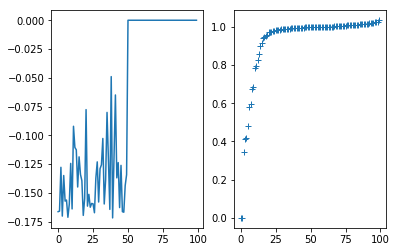

The eigenvector is noisy and thus the clustering will fail. Let's switch instead to random-walk Laplacian


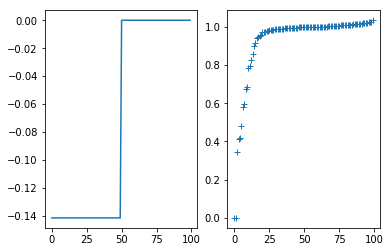

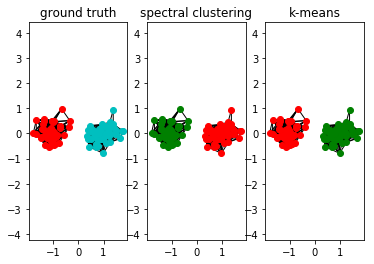

In [111]:
eps = 0.2
laplacian_normalization = 'rw'       #either 'unn', 'sym' or 'rw' 
chosen_eig_indices = np.array([1]) # indices of the ordered eigenvalues to pick

W = build_similarity_graph(X, var=var, eps=eps)

L = build_laplacian(W, laplacian_normalization="sym")
Y_rec, E = spectral_clustering(L, chosen_eig_indices, num_classes, debug=True)
print("The eigenvector is noisy and thus the clustering will fail. Let's switch instead to random-walk Laplacian")
L = build_laplacian(W, laplacian_normalization=laplacian_normalization)
Y_rec, E = spectral_clustering(L, chosen_eig_indices, num_classes, debug=True)
plot_clustering_result(X, Y, L, Y_rec,skc.KMeans(num_classes).fit_predict(X))

**2.3. Look at `find_the_bend`. Generate a dataset with 4 blobs and $\sigma^2 = 0.03$. 
Build a graph out of it and plot the first 15 eigenvalues of the Laplacian. Complete `choose_eig_function` to automatically choose the number of eigenvectors to include. 
The decision rule must adapt to the actual eigenvalues of the problem.**

The selected indices are: 1, 2, 3


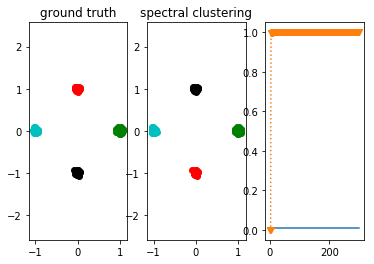

In [9]:
# the number of samples to generate
num_samples = 600
sigma2 = 0.03
[X, Y] = blobs(num_samples, 4, sigma2)
num_classes = len(np.unique(Y))
dists = sd.cdist(X, X, 'euclidean')**2
exponential_euclidean = np.exp(-dists)
var = np.var(exponential_euclidean)

eps=0.1
laplacian_normalization = 'rw'
W = build_similarity_graph(X, var=var, eps=eps)
L = build_laplacian(W, laplacian_normalization=laplacian_normalization)

E, _ = sp.linalg.eig(L)#, num_classes)
E = np.sort(E.real)
chosen_eig_indices = choose_eig_function(E) # indices of the ordered eigenvalues to pick
threshold = E[chosen_eig_indices[-1]]+1e-2
s = ", ".join([str(i) for i in chosen_eig_indices])
print(f"The selected indices are: {s}")

Y_rec, E = spectral_clustering(L, chosen_eig_indices, num_classes)

plot_the_bend(X, Y, L, Y_rec, E, threshold=threshold)


Using `spectral_clustering_adaptive`

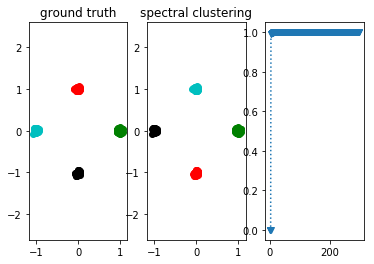

In [154]:
Y_rec, E = spectral_clustering_adaptive(L, num_classes)

plot_the_bend(X, Y, L, Y_rec, E)

**2.4. Now increase the variance of the blobs to $\sigma_2 = 0.20$ as you keep plotting the eigenvalues. 
Use `choose_eig_function`. Do you see any difference?**

The clustering remain robust to more noisy data. However, $\epsilon$ can be increased to sparsify the similarities matrix.

The selected indices are: 1, 2, 3


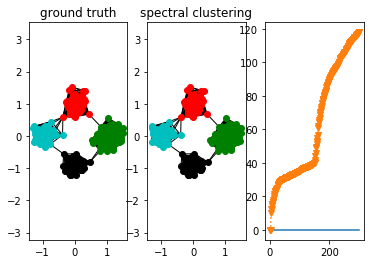

In [140]:
# the number of samples to generate
num_samples = 600
sigma2 = 0.2
[X, Y] = blobs(num_samples, 4, sigma2)
num_classes = len(np.unique(Y))
dists = sd.cdist(X, X, 'euclidean')**2
exponential_euclidean = np.exp(-dists)
var = np.var(exponential_euclidean)

eps = 0.3
laplacian_normalization = 'unn'
W = build_similarity_graph(X, var=var, eps=eps)
L = build_laplacian(W, laplacian_normalization=laplacian_normalization)

E, _ = sp.linalg.eig(L)#, num_classes)
E = np.sort(E.real)
chosen_eig_indices = choose_eig_function(E) # indices of the ordered eigenvalues to pick
threshold = E[chosen_eig_indices[-1]]+1e-2
s = ", ".join([str(i) for i in chosen_eig_indices])
print(f"The selected indices are: {s}")

Y_rec, E = spectral_clustering(L, chosen_eig_indices, num_classes)

plot_the_bend(X, Y, L, Y_rec, E, threshold=threshold)

**2.5. When you built the cluster assignment did you use thresholding, kmeans or both? Do you have any opinion on when to use each?**

The cluster assignement used kmeans. Kmeans is particularly efficient when the clusters are drawn from a Gaussian distribution. It is not necessarly the case. 
On the other hand, thresholding is usually less efficient, but it is less computationnally expensive. Moreover, thresholding allow to detect outliers [1].


SCAMS [2] suggests an alternative by using an ADMM method for partitioning.

[[1] - 
Subspace Clustering via Thresholding and Spectral Clustering
Reinhard Heckel, Helmut Bölcskei](https://arxiv.org/abs/1303.3716)
[[2] - SCAMS: Simultaneous Clustering and Model Selection, Zhuwen Li, Loong-Fah Cheong and Steven Zhiying Zhou](https://www.ece.nus.edu.sg/stfpage/eleclf/Li_SCAMS_Simultaneous_Clustering_2014_CVPR_paper.pdf)


**2.6 What is another use that looking at the distribution of the eigenvalues can have during clustering, beside choosing which eigenvectors to include?**

The eigenvalues can be used to compute the Moore-Pensore pseudo-inverse of G, which allows us to compute the cummute distance $c_{ij}$ between vertex i and vertex j:

$$c_{ij} =vol(G)(e_i − e_j )^T L^†(e_i − e_j )$$

This result has been published by Klein and Randic [3]

[[3] Klein, Douglas J., and Milan Randić. "Resistance distance." Journal of mathematical chemistry 12.1 (1993): 81-95.](https://link.springer.com/content/pdf/10.1007/BF01164627.pdf)

**2.7. Plot your results using spectral clustering and k-means in `two_moons_clustering` and compare the results. Do you notice any difference? Taking into consideration the graph structure, can you explain them?**

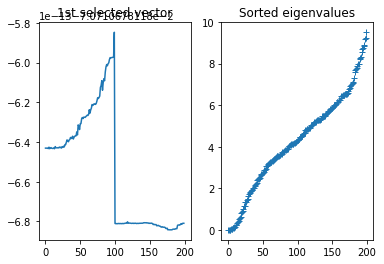

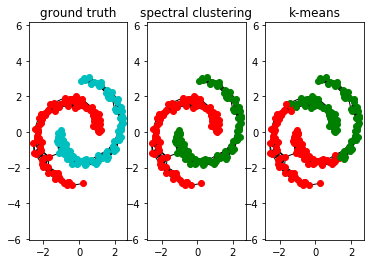

In [52]:
in_data =scipy.io.loadmat('data/data_2moons')
X = in_data['X']
Y = in_data['Y']
num_classes = len(np.unique(Y))

eps = 0.01
dists = sd.cdist(X, X, 'euclidean')**2
exponential_euclidean = np.exp(-dists)
var = np.var(exponential_euclidean)

laplacian_normalization = 'unn'; #either 'unn'normalized, 'sym'metric normalization or 'rw' random-walk normalization
W = build_similarity_graph(X, var=var, eps=eps)
L = build_laplacian(W, laplacian_normalization=laplacian_normalization)

Y_rec, E = spectral_clustering_adaptive(L, num_classes, debug=True)
# plot_the_bend(X, Y, L, Y_rec, eigenvalues)

plot_clustering_result(X, Y, L, Y_rec,skc.KMeans(num_classes).fit_predict(X))

The clustering is harder to tune. One should first remark that some points are very close to each other while not belonging to the same moon. This explains why k-means is not appropriate here. 

This also explains that tuning $\epsilon$ is quite difficult. As in 2.1, I selected this parameter by finding a value that separates clearly the eigenvectors.

**2.8. `point_and_circle_clustering` will compare spectral clustering using the normal laplacian $L$ and the random-walk regularized Laplacian $L_{rw}$. Do you notice any difference? Taking into consideration the graph structure, can you explain them?**

The random walk is less appropriate than the normal Laplacian for this type of data. Indeed, one cluster is denser than the other one. Therefore, the hitting time on this cluster is significantly different than on the other one and the ramdom walker might get lost. 

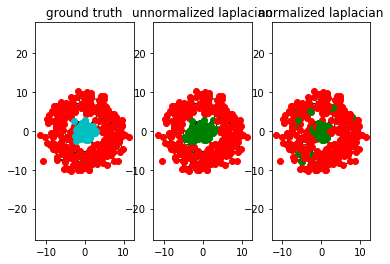

In [85]:
in_data =scipy.io.loadmat('data/data_pointandcircle')
X = in_data['X']
Y = in_data['Y']
num_classes = len(np.unique(Y))

dists = sd.cdist(X, X, 'euclidean')**2
exponential_euclidean = np.exp(-dists)
var = np.var(exponential_euclidean)


chosen_eig_indices =  [1, 2] # indices of the ordered eigenvalues to pick

# build laplacian
eps = 1e-1
k = 0
var = 1
W = build_similarity_graph(X, var=var, eps=eps, k=k)
L_unn = build_laplacian(W, laplacian_normalization="unn")

eps = 0.01
var = np.var(exponential_euclidean)
W = build_similarity_graph(X, var=var, eps=eps, k=k)
L_norm = build_laplacian(W, laplacian_normalization="rw")

Y_unn, E = spectral_clustering(L_unn, chosen_eig_indices, num_classes)
Y_norm, E = spectral_clustering(L_norm, chosen_eig_indices, num_classes)


plot_clustering_result(X, Y, L_unn, Y_unn, Y_norm, 1);


**How did you choose the parameters when building the graph?**

The selection of the parameter was done following the plot of the eigenvalues and the second eigenvector as in previous questions. However, the tune was harder and I had to change the variance of the Laplacian to balance the difference the two clusters.

**2.9. Complete `parameter_sensitivity`, and generate a plot of the ARI index while varying one of the parameters in the graph construction $\epsilon$ or `k`. Comment on the stability of spectral clustering.**

Our algorithm of spectral clustering is not robust, because we have to carefully select the best parameter.

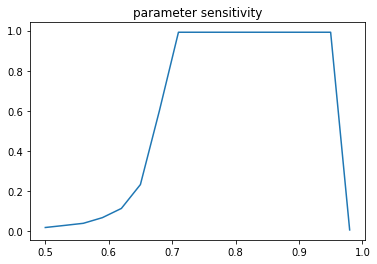

In [59]:
num_samples = 500;

dists = sd.cdist(X, X, 'euclidean')**2
exponential_euclidean = np.exp(-dists)
var = np.var(exponential_euclidean)


laplacian_normalization = "rw"; #either 'unn'normalized, 'sym'metric normalization or 'rw' random-walk normalization
chosen_eig_values = [1]

parameter_candidate = np.arange(0.5, 1., 0.03)  # the number of neighbours for the graph or the epsilon threshold
parameter_performance=[]

[X, Y] = two_moons(num_samples,1,0.02)
num_classes = len(np.unique(Y))
    

for eps in parameter_candidate:
    
    W = build_similarity_graph(X, eps=eps)
    L =  build_laplacian(W, laplacian_normalization=laplacian_normalization)
    Y_rec, E = spectral_clustering(L, chosen_eig_values, num_classes)

    parameter_performance += [skm.adjusted_rand_score(Y,Y_rec)]

plt.figure()
plt.plot(parameter_candidate, parameter_performance)
plt.title('parameter sensitivity')
plt.show()

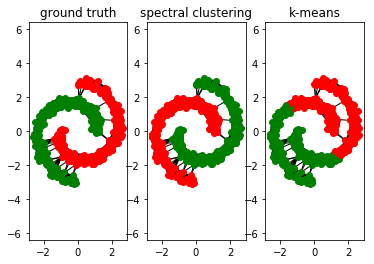

In [60]:
eps = parameter_candidate[np.argmax(parameter_performance)]
W = build_similarity_graph(X, eps=eps)
L =  build_laplacian(W, laplacian_normalization="rw")
Y_rec, E = spectral_clustering(L, [1], num_classes)
plot_clustering_result(X, Y, L, Y_rec,skc.KMeans(num_classes).fit_predict(X))

**2.10. If we did not have access to true labels how could we evaluate the clustering result (or what should we not use as evaluation)?**

Without the true labels, we should not tempted to measure the quality of the clustering directly through `Y_rec`. Instead, we should measure some properties of the clusters: are they well balanced? for example.

A measure was proposed by Ravi Kannan, Santosh Vempala and Adrian Vetta [4] to define the quality of a given clustering. A clustering is said to ($\alpha$, $\epsilon$)-clustering if the conductance of each cluster is at least $\alpha$ and the weight of the inter-cluster edges is at most $\epsilon$ fraction of the total weight of all the edges in the graph. 

[[4] Kannan, Ravi, Santosh Vempala, and Adrian Vetta. "On clusterings: Good, bad and spectral." Journal of the ACM (JACM) 51.3 (2004): 497-515.](http://cogcomp.org/sites/aiis/ARCHIVE/2003-SPRING/papers/SPRING2003/on-clusterings-good-bad.pdf)

## 3. Image Segmentation

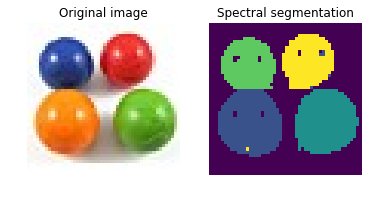

In [107]:
from skimage import io
import numpy as np
import scipy.spatial.distance as sd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
path=os.path.dirname(os.getcwd())
sys.path.append(path)
from helper import *
from graph_construction.func import *
from spectral_clustering.func import *

def image_segmentation(filename, n_clusters):
    X = io.imread(filename)
    X=(X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X,1)
    Xr=X.reshape(im_side**2,3)

    dists = sd.cdist(Xr, Xr, 'euclidean')**2
    exponential_euclidean = np.exp(-dists)
    var = np.var(exponential_euclidean)

    eps = 1e-3
    W = build_similarity_graph(Xr, eps=eps)
    L =  build_laplacian(W, laplacian_normalization="rw")
    Y_rec, E = spectral_clustering(L, [1,2,3], n_clusters)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(X)
    plt.axis('off')
    plt.title("Original image")
    plt.subplot(1,2,2)
    plt.axis('off')
    Y_rec=Y_rec.reshape(im_side,im_side)
    plt.imshow(Y_rec)
    plt.title("Spectral segmentation")

image_segmentation("four_elements.bmp", 5)


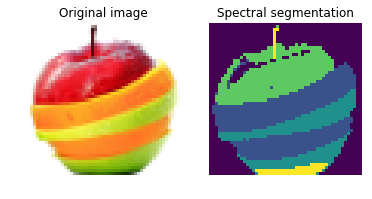

In [109]:
image_segmentation("fruit_salad.bmp", 5)

**3.2. A full graph built between the pixels of a 50 × 50 image corresponds to 502 nodes. 
Solving the full eigenvalue problem in this case would scale in the order of 234. 
Even on weak hardware this takes only seconds to minutes. 
Segmenting a Full HD picture of 1920 × 1080 would scale in the order of 264 (about a month).
Beyond that, the large picture would require to store in memory a graph over millions of nodes. 
A full graph on that scale requires about 1TB of memory. 
Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?**

- First, one could use sparse matrices for storing the similarities. Using k-nn or $\epsilon$ fills out the values. In this direction, matrix-free algorithms were developed, as the Lanczos algorithm.

- Secondly, the partitining step could be achieved by recursively partitioning the subsets method as for hierarchical clustering.

- Finally, for large-sized graphs, ill-conditioned matrix can terribly slow the convergence of eigenvalue solvers. Preconditioning is often necessary.



**3.3. Did you use eig or eigs to extract the final eigenvectors? Shortly, what is the difference between the two? How do they scale to large graphs (order of complexity)?**

I have used eig, which a general purpose eigenvalue solver. It is appropriate for problems that fit well in memory and when all eigenvalues or eigenvectors need to be known. 

eigs is a different solvers, based on ARPACK, which is more appropriate when only a limite subset of eigenvalues is required. For eigs, the matrix can be stored in sparse format.
